In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import scipy.stats
from tqdm import tqdm
#from autoencoder_helper import gaussian_1d, likelihood_loss

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

load = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,50)
        self.enc2 = nn.Linear(50,25)
        self.enc3 = nn.Linear(25,10)
        
        # decoder
        self.dec1 = nn.Linear(10, 25)
        self.dec2 = nn.Linear(25, 50)
        self.dec3 = nn.Linear(50, n_output)

    def forward(self, x):
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.enc3(x))
        x = torch.relu(self.dec1(x))
        x = torch.relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [3]:
#generate training data of uni and bimodal Gaussians

n_input = 100
n_output = n_input # n_output == n_input for autoencoders

n_train_data = 20000
train_data = np.empty((0,n_input), float)
test_data = np.empty((0,n_input), float)

train_stats = np.empty((0,2), float) # train_stats[i,0] is the mean, train_stats[i,1] is the stddev
test_stats = np.empty((0,2), float)

for i in tqdm(range(n_train_data)):
    
    # unimodal train data
    mean1 = random.uniform(-1,1)
    std1 = random.uniform(1,5)
    uni_data1 = np.random.normal(mean1, std1, size = (1,n_input))
    train_data = np.append(train_data, uni_data1, axis = 0 )
    train_stats = np.append(train_stats, [[mean1, std1]], axis = 0)
    
    # unimodal test data
    mean2 = random.uniform(-1,1)
    std2 = random.uniform(1,5)
    uni_data2 = np.random.normal(mean2, std2, size = (1,n_input))
    test_data = np.append(test_data, uni_data2, axis = 0 )
    test_stats = np.append(test_stats, [[mean2, std2]], axis = 0)
    
#     #bimodal train data
#     mean1 = random.uniform(-1,1)
#     mean2 = random.uniform(-1,1)
#     std1 = random.uniform(1,5)
#     std2 = random.uniform(1,5)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data1 = np.concatenate([x1,x2], axis =1)
#     train_data = np.append(train_data, bi_data1, axis= 0)

#     #bimodal test data
#     mean1 = random.uniform(-1,1)
#     mean2 = random.uniform(-1,1)
#     std1 = random.uniform(1,5)
#     std2 = random.uniform(1,5)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data2 = np.concatenate([x1,x2], axis =1)
#     test_data = np.append(test_data, bi_data2, axis=0)
    
train_data = train_data.astype(np.float32)
train_data = np.sort(train_data, axis=1)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)
# for i in range(train_data.shape[0]):
#     train_data[i,:] = (train_data[i,:] - train_stats[i,0] ) / train_stats[i,1]

test_data = test_data.astype(np.float32)
test_data = np.sort(test_data, axis=1)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)
# for i in range(train_data.shape[0]):
#     test_data[i,:] = (test_data[i,:] - test_stats[i,0] ) / test_stats[i,1]

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 334.79it/s]


In [57]:
epochs_end = 10000
epochs_start = 0
batch_size = 32
n_batch = n_train_data//batch_size
net = Net(n_input, n_output)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
net.train()

Net(
  (enc1): Linear(in_features=100, out_features=50, bias=True)
  (enc2): Linear(in_features=50, out_features=25, bias=True)
  (enc3): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=100, bias=True)
)

In [27]:
# if load:
#     net = Net(n_input, n_output)
#     net = net.to(device)
#     checkpoint = torch.load('model_ll_dropout_lr_0.001.pt')
#     net.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epochs_start = checkpoint['epoch']

In [6]:
# for e in range(epochs_start, epochs_end):

#     print("Current epoch number: {}".format(e))
#     for i in range(n_batch):
#         mini_batch_data = train_data[i*batch_size:(i+1)*batch_size, :]
#         mini_batch_data = mini_batch_data.to(device)
#         prediction = net(mini_batch_data)
#         loss = likelihood_loss(prediction, i) 
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     if (e+1) % 10 == 0 :
#         net.eval()
#         train_pred = net(train_data)
#         loss = likelihood_loss(full_pred, -1, train=False)
#         train_loss = loss.item()
        
#         test_pred = net(test_data)
#         loss = likelihood_loss(full_pred, -1, train=False)
#         test_loss = loss.item()
#         net.train()
        
#         print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
# #         torch.save({
# #             'epoch': e,
# #             'model_state_dict': net.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict()
# #         }, 'model.pt')
        


In [11]:
def gaussian_1d(x, mean, std, tensor=True):
    if tensor:
        return 1/np.sqrt(2*np.pi*std**2) * torch.exp(-(x-mean)**2/(2*std**2))
    else:
        return 1/np.sqrt(2*np.pi*std**2) * np.exp(-(x-mean)**2/(2*std**2))

def likelihood_loss(prediction, i, stats, batch=True):
    
    if batch:
        data_stats = stats[i*batch_size:(i+1)*batch_size, :]
    else:
        data_stats = stats
            
    for j in range(data_stats.shape[0]):
        mean = data_stats[j,0]
        stddev = data_stats[j,1]
        pdf_vals = gaussian_1d(prediction[j,:], mean, stddev)
        _ll = -torch.mean(torch.log(pdf_vals)).reshape(1) # so it is not a zero-dimensional tensor
        if j == 0:
            ll = torch.clone(_ll)
        else:
            ll = torch.cat((ll,_ll))
    ll_val = torch.mean(ll)
    return ll_val


In [58]:
lower_lim = 0
upper_lim = 0.25

Current epoch number: 4
Epoch 4, train loss: 1.954427, test loss: 1.950462


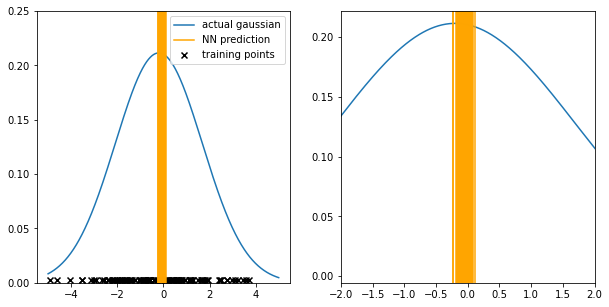

Current epoch number: 9
Epoch 9, train loss: 1.939656, test loss: 1.941551


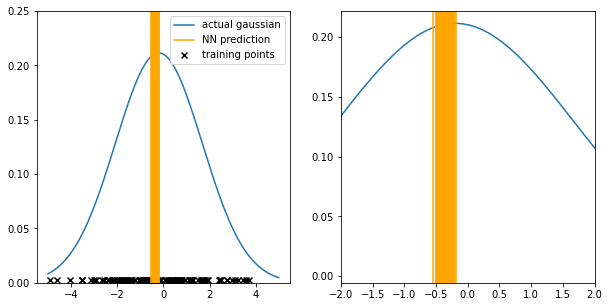

Current epoch number: 14
Epoch 14, train loss: 1.935220, test loss: 1.941587


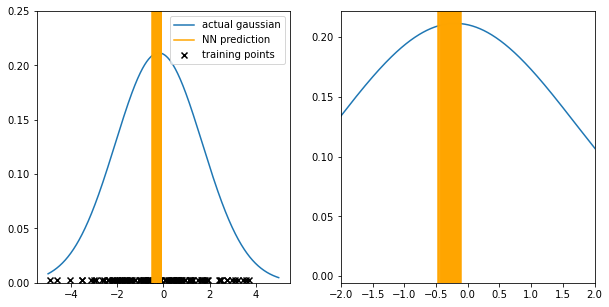

Current epoch number: 19
Epoch 19, train loss: 1.934191, test loss: 1.939084


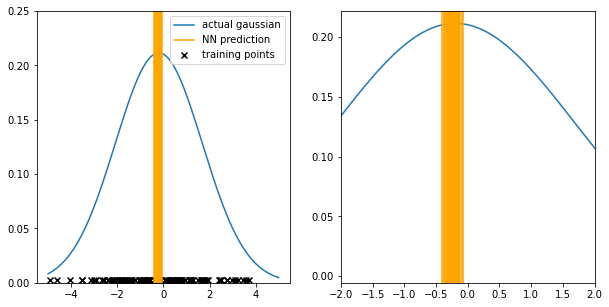

Current epoch number: 24
Epoch 24, train loss: 1.934006, test loss: 1.937989


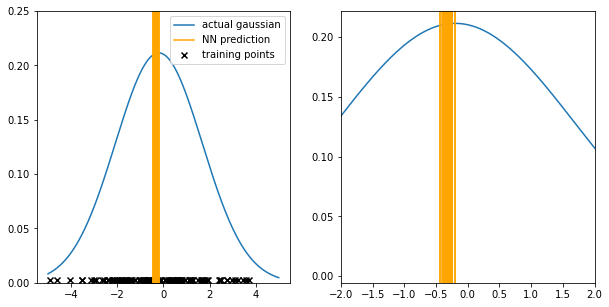

Current epoch number: 29
Epoch 29, train loss: 1.933699, test loss: 1.937522


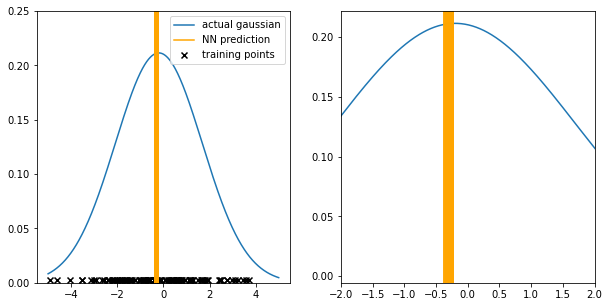

Current epoch number: 34
Epoch 34, train loss: 1.933320, test loss: 1.937366


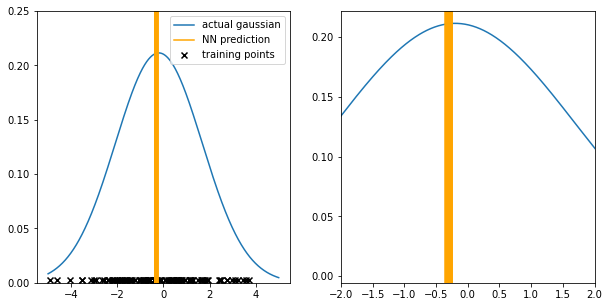

Current epoch number: 39
Epoch 39, train loss: 1.933111, test loss: 1.937314


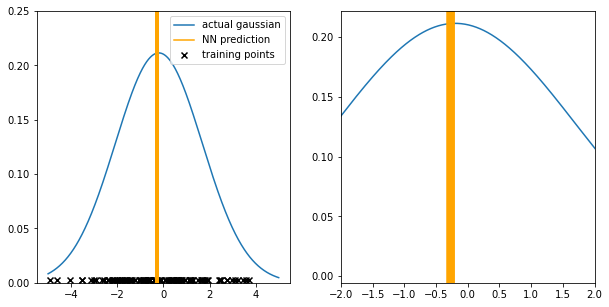

Current epoch number: 44
Epoch 44, train loss: 1.932955, test loss: 1.937298


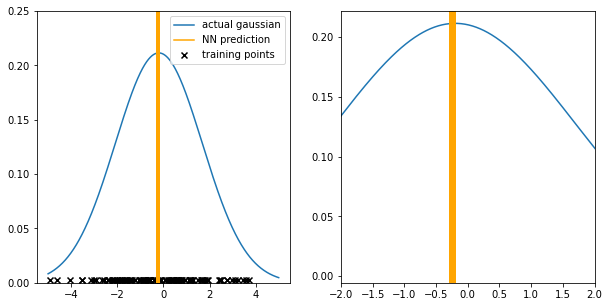

Current epoch number: 49
Epoch 49, train loss: 1.932871, test loss: 1.937262


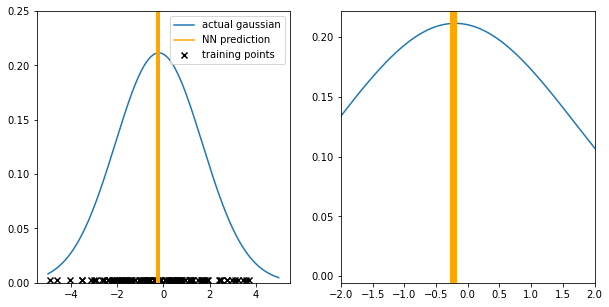

Current epoch number: 54
Epoch 54, train loss: 1.932866, test loss: 1.937169


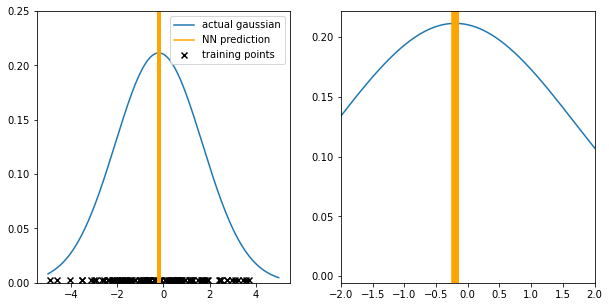

Current epoch number: 59
Epoch 59, train loss: 1.932837, test loss: 1.937118


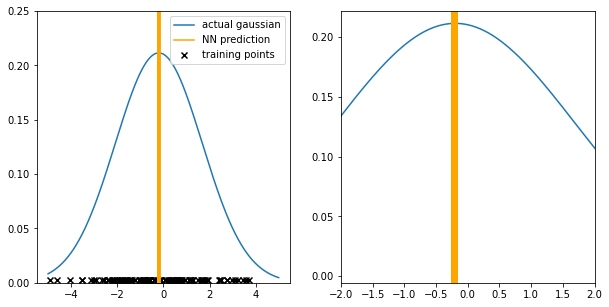

Current epoch number: 64
Epoch 64, train loss: 1.932795, test loss: 1.937114


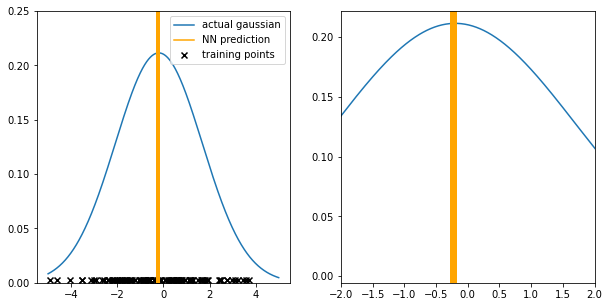

Current epoch number: 69
Epoch 69, train loss: 1.932791, test loss: 1.937088


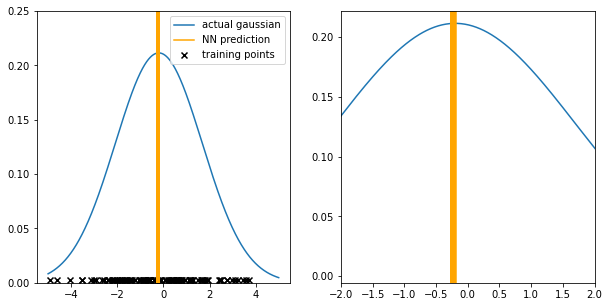

Current epoch number: 74
Epoch 74, train loss: 1.932771, test loss: 1.937077


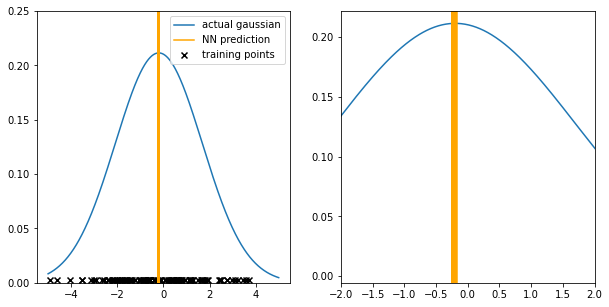

Current epoch number: 79
Epoch 79, train loss: 1.932756, test loss: 1.937064


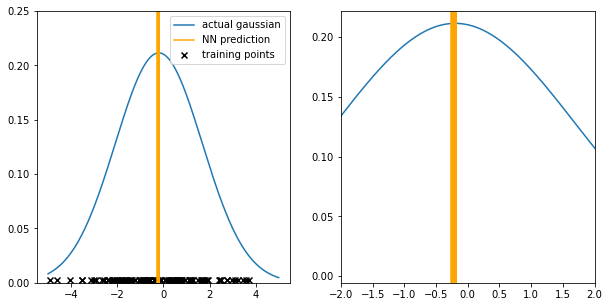

Current epoch number: 84
Epoch 84, train loss: 1.932746, test loss: 1.937056


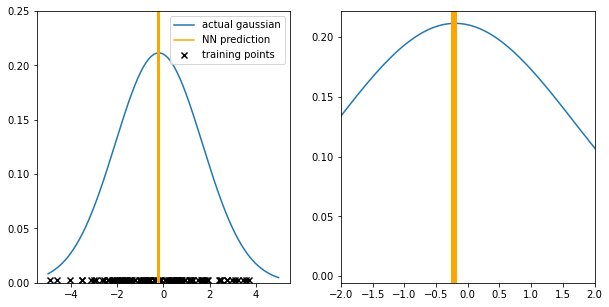

Current epoch number: 89
Epoch 89, train loss: 1.932735, test loss: 1.937043


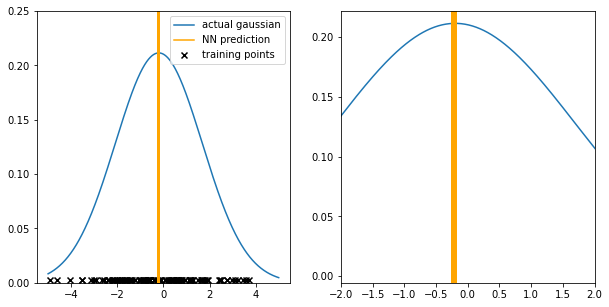

Current epoch number: 94
Epoch 94, train loss: 1.932725, test loss: 1.937036


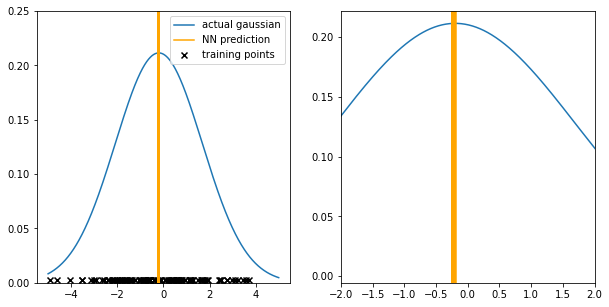

Current epoch number: 99
Epoch 99, train loss: 1.932716, test loss: 1.937027


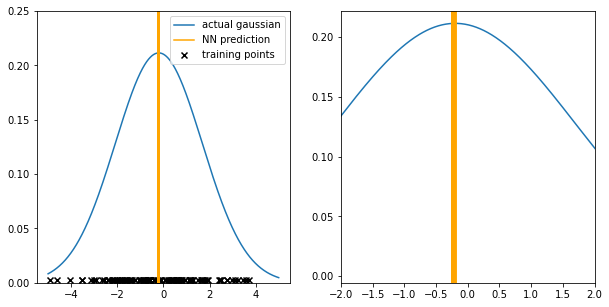

Current epoch number: 104
Epoch 104, train loss: 1.932708, test loss: 1.937021


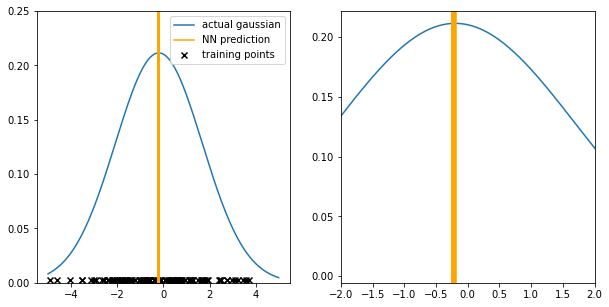

Current epoch number: 109
Epoch 109, train loss: 1.932701, test loss: 1.937014


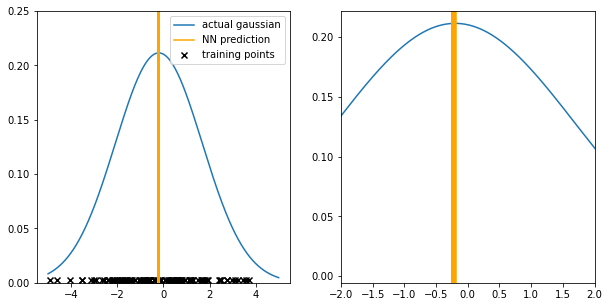

Current epoch number: 114
Epoch 114, train loss: 1.932696, test loss: 1.937010


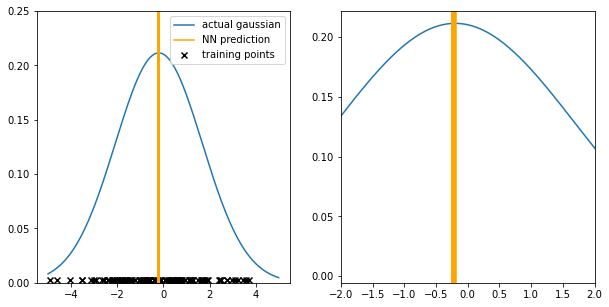

Current epoch number: 119
Epoch 119, train loss: 1.932690, test loss: 1.937005


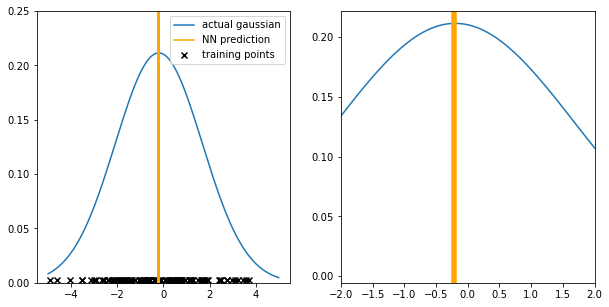

Current epoch number: 124
Epoch 124, train loss: 1.932686, test loss: 1.937003


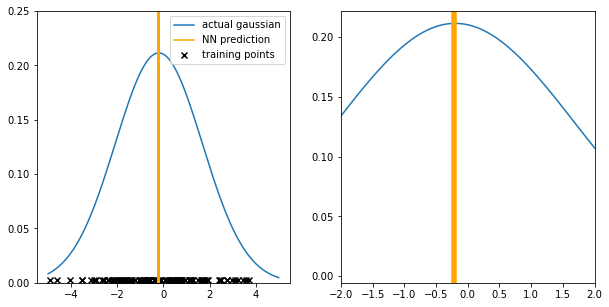

Current epoch number: 129
Epoch 129, train loss: 1.932681, test loss: 1.937001


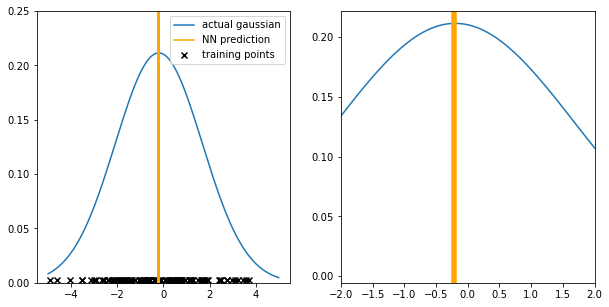

Current epoch number: 134
Epoch 134, train loss: 1.932678, test loss: 1.936998


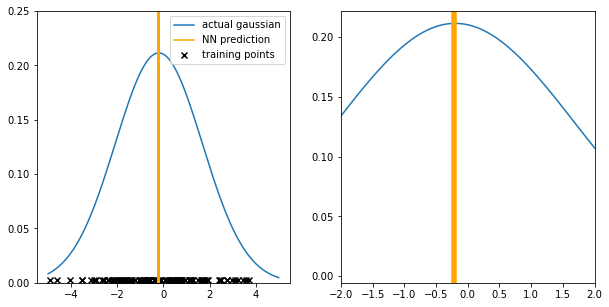

Current epoch number: 139
Epoch 139, train loss: 1.932674, test loss: 1.936997


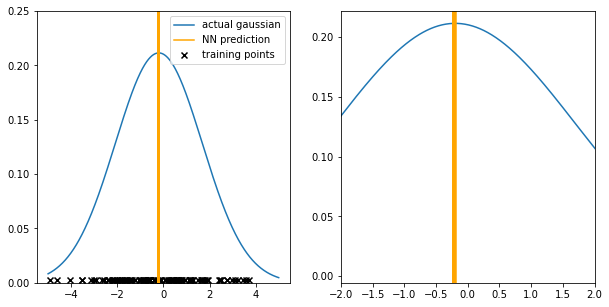

Current epoch number: 144
Epoch 144, train loss: 1.932672, test loss: 1.936995


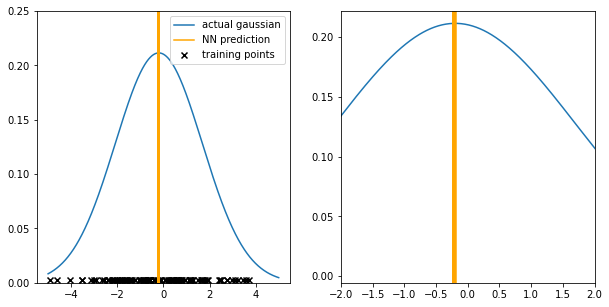

Current epoch number: 149
Epoch 149, train loss: 1.932669, test loss: 1.936994


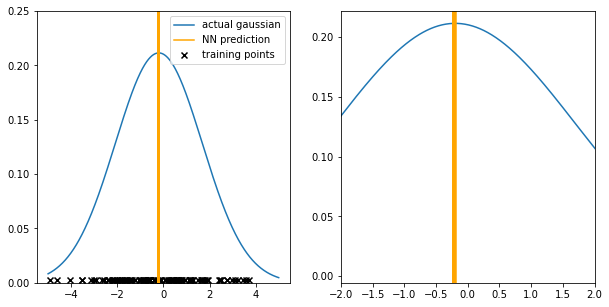

Current epoch number: 154
Epoch 154, train loss: 1.932668, test loss: 1.936996


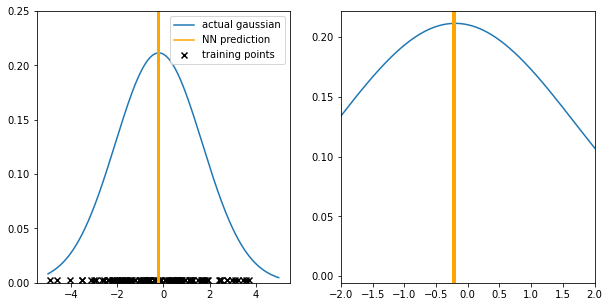

Current epoch number: 159
Epoch 159, train loss: 1.932675, test loss: 1.937004


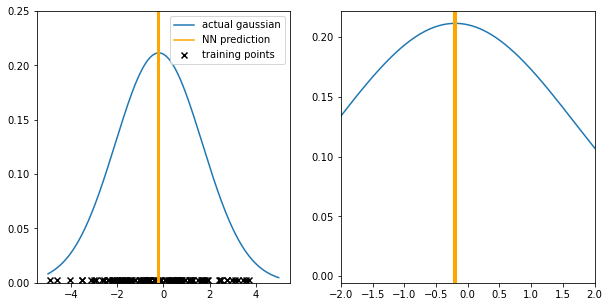

Current epoch number: 164
Epoch 164, train loss: 1.932792, test loss: 1.937159


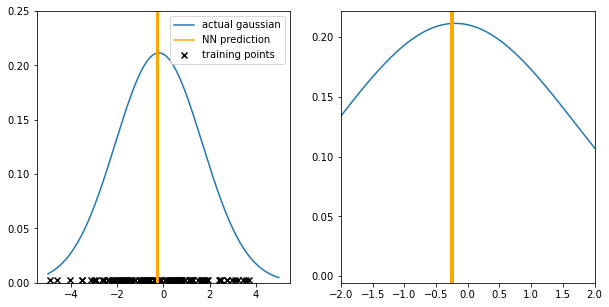

Current epoch number: 169
Epoch 169, train loss: 1.932664, test loss: 1.937032


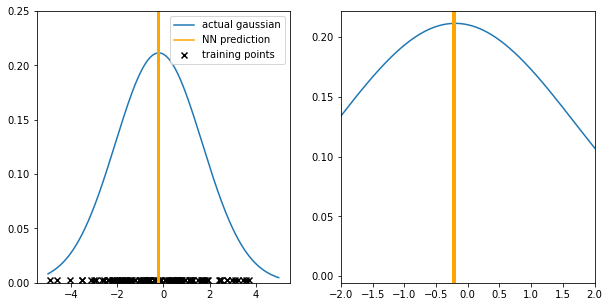

Current epoch number: 174
Epoch 174, train loss: 1.932667, test loss: 1.937028


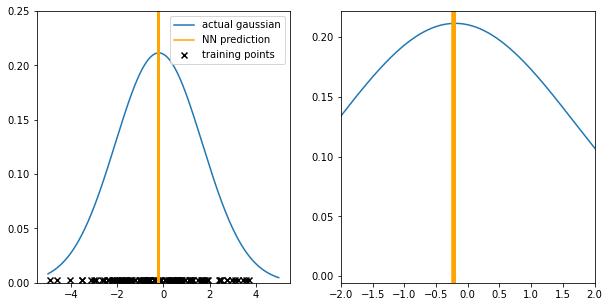

Current epoch number: 179
Epoch 179, train loss: 1.932674, test loss: 1.937018


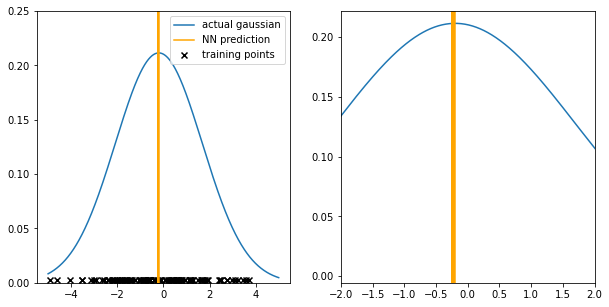

Current epoch number: 184
Epoch 184, train loss: 1.932673, test loss: 1.937007


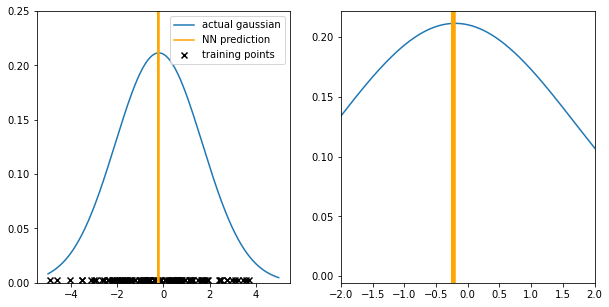

Current epoch number: 189
Epoch 189, train loss: 1.932667, test loss: 1.937001


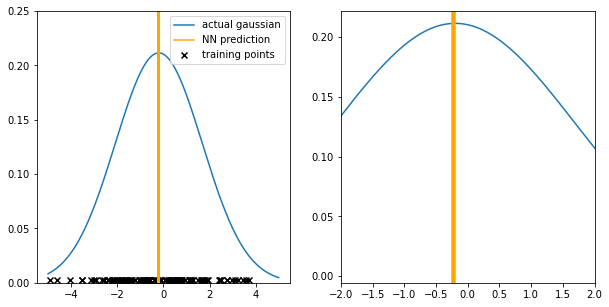

Current epoch number: 194
Epoch 194, train loss: 1.932661, test loss: 1.936997


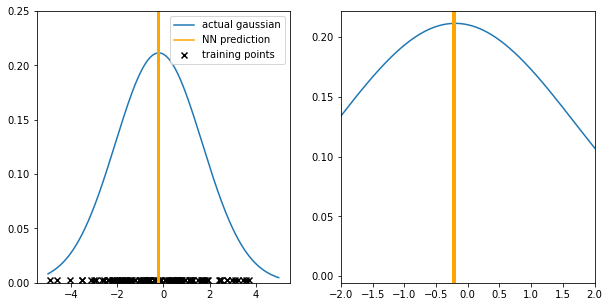

Current epoch number: 199
Epoch 199, train loss: 1.932654, test loss: 1.936990


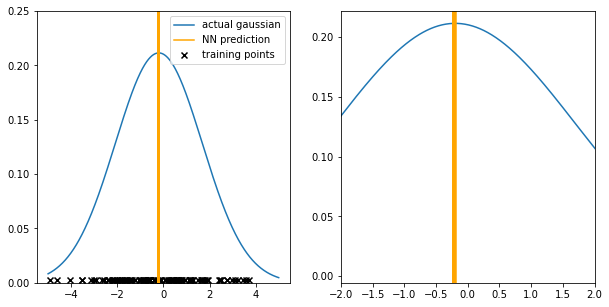

Current epoch number: 204
Epoch 204, train loss: 1.932657, test loss: 1.936985


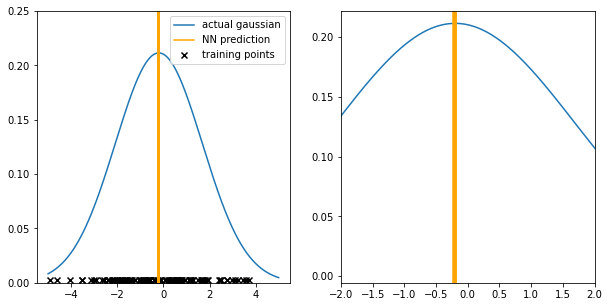

Current epoch number: 209
Epoch 209, train loss: 1.932652, test loss: 1.936984


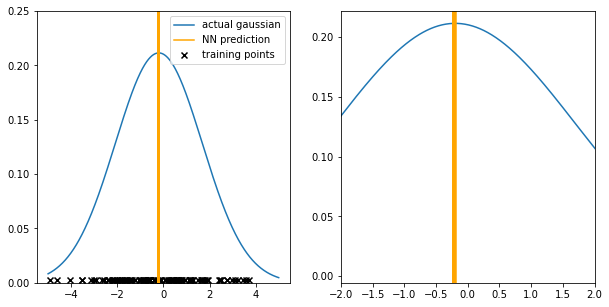

Current epoch number: 214
Epoch 214, train loss: 1.932654, test loss: 1.936993


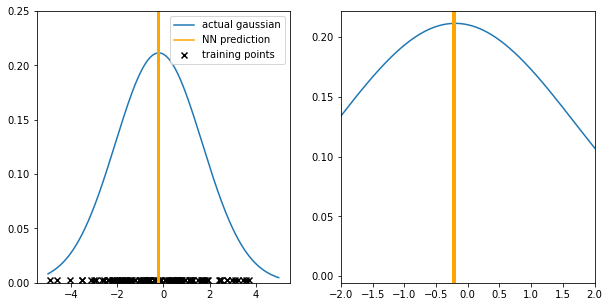

Current epoch number: 219
Epoch 219, train loss: 1.932668, test loss: 1.937001


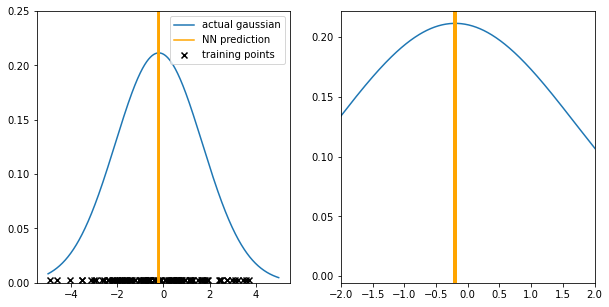

Current epoch number: 224
Epoch 224, train loss: 1.932697, test loss: 1.937041


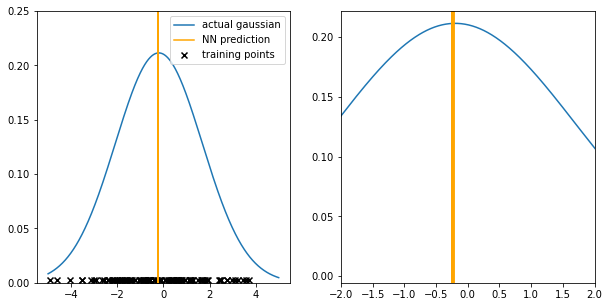

Current epoch number: 229
Epoch 229, train loss: 1.932663, test loss: 1.936987


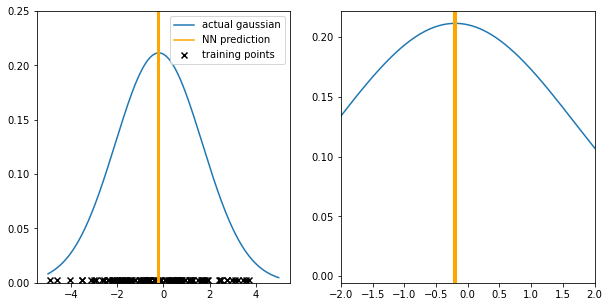

Current epoch number: 234
Epoch 234, train loss: 1.932658, test loss: 1.936996


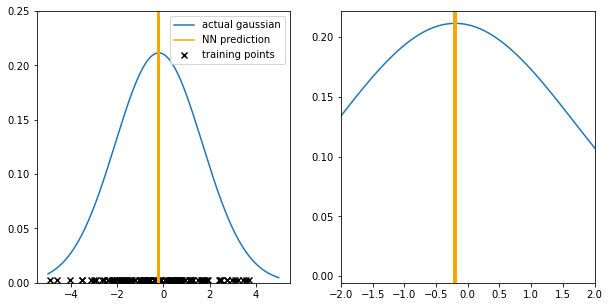

Current epoch number: 239
Epoch 239, train loss: 1.932667, test loss: 1.937006


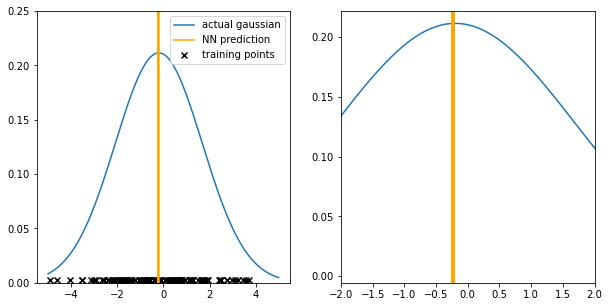

Current epoch number: 244
Epoch 244, train loss: 1.932648, test loss: 1.936984


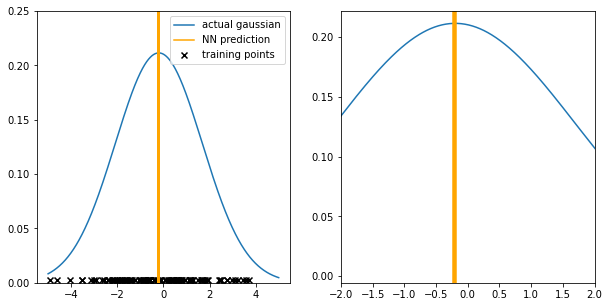

Current epoch number: 249
Epoch 249, train loss: 1.932647, test loss: 1.936985


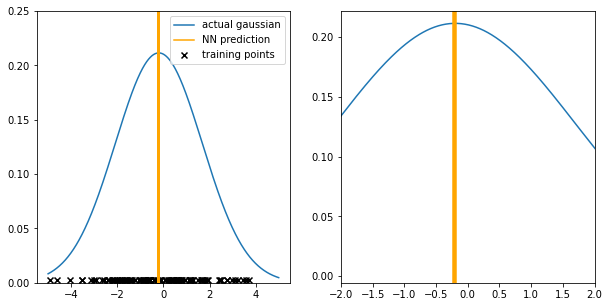

Current epoch number: 254
Epoch 254, train loss: 1.932665, test loss: 1.937023


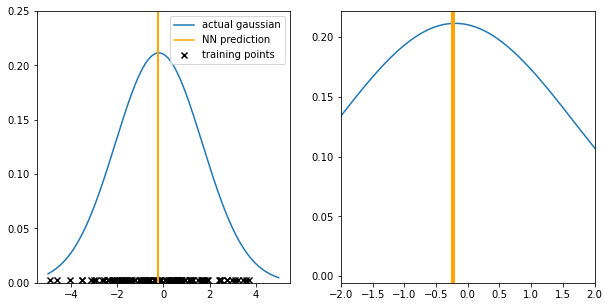

Current epoch number: 259
Epoch 259, train loss: 1.932822, test loss: 1.937170


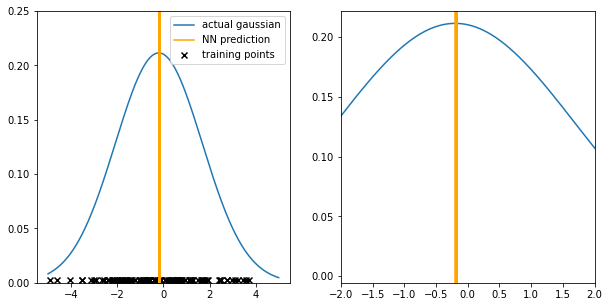

Current epoch number: 264
Epoch 264, train loss: 1.932653, test loss: 1.937028


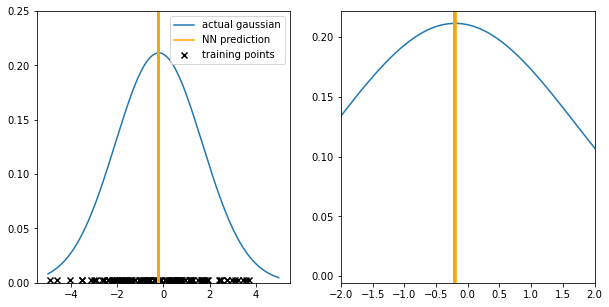

Current epoch number: 269
Epoch 269, train loss: 1.932655, test loss: 1.937017


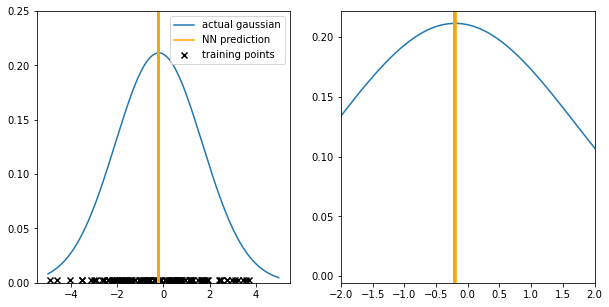

Current epoch number: 274
Epoch 274, train loss: 1.932660, test loss: 1.937006


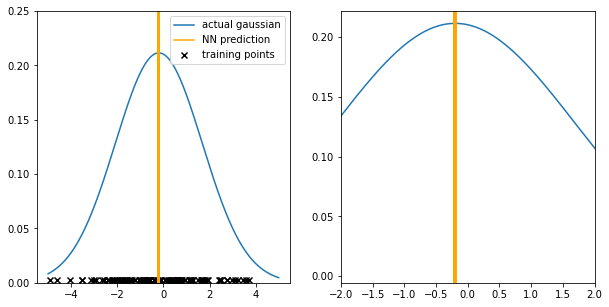

Current epoch number: 279
Epoch 279, train loss: 1.932656, test loss: 1.936998


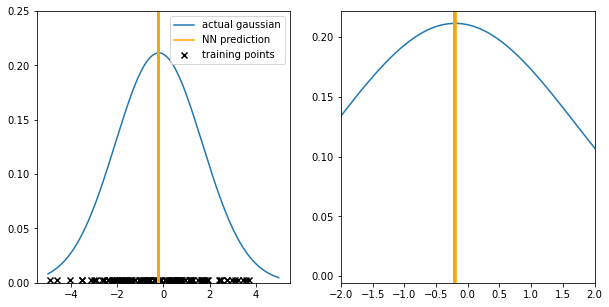

Current epoch number: 284
Epoch 284, train loss: 1.932647, test loss: 1.936991


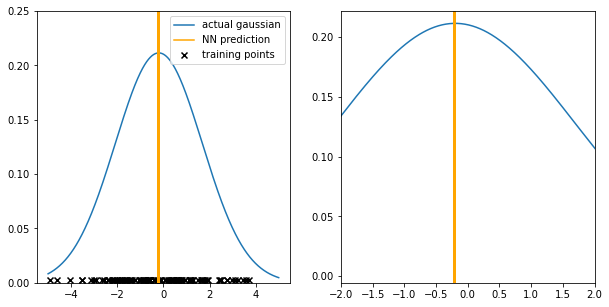

Current epoch number: 289
Epoch 289, train loss: 1.932641, test loss: 1.936984


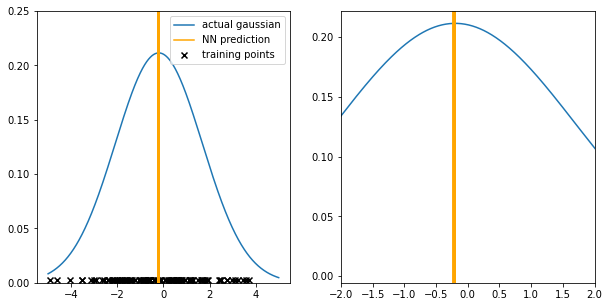

Current epoch number: 294
Epoch 294, train loss: 1.932643, test loss: 1.936983


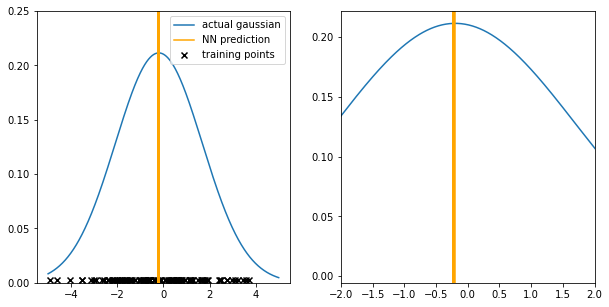

Current epoch number: 299
Epoch 299, train loss: 1.932645, test loss: 1.936991


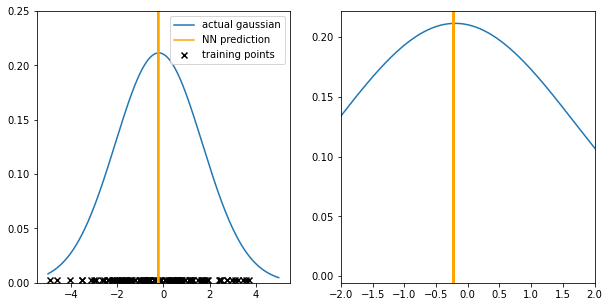

Current epoch number: 304
Epoch 304, train loss: 1.932640, test loss: 1.936982


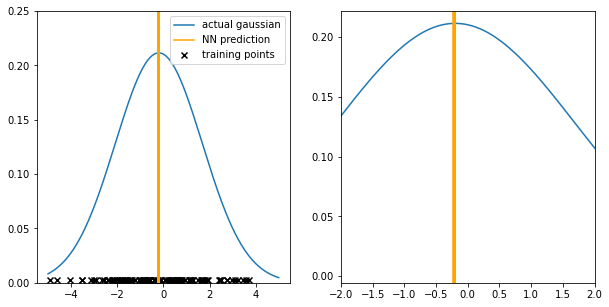

Current epoch number: 309
Epoch 309, train loss: 1.932640, test loss: 1.936983


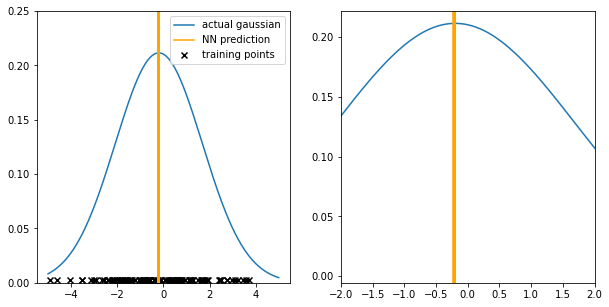

Current epoch number: 314
Epoch 314, train loss: 1.932647, test loss: 1.936999


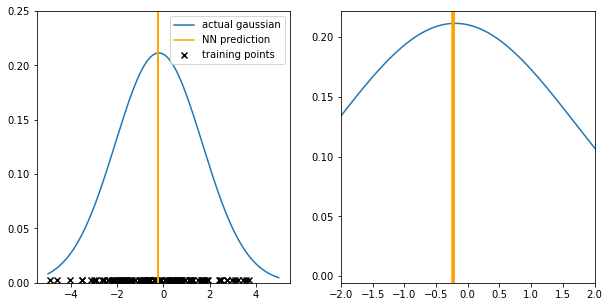

Current epoch number: 319
Epoch 319, train loss: 1.932696, test loss: 1.937047


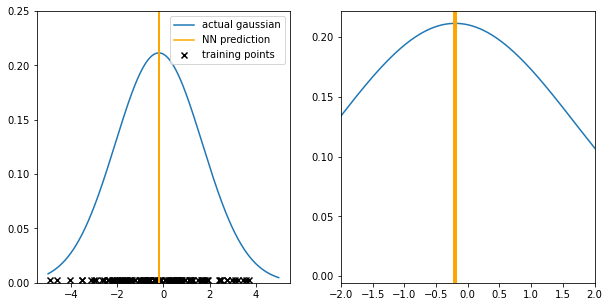

Current epoch number: 324
Epoch 324, train loss: 1.932679, test loss: 1.936998


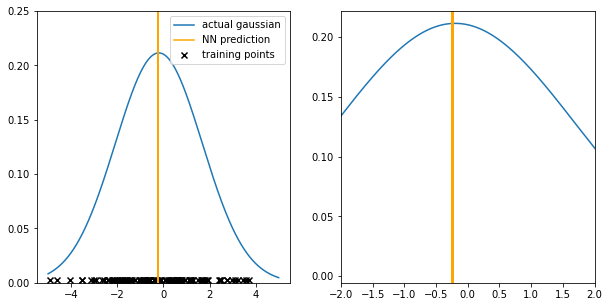

Current epoch number: 329
Epoch 329, train loss: 1.932678, test loss: 1.937021


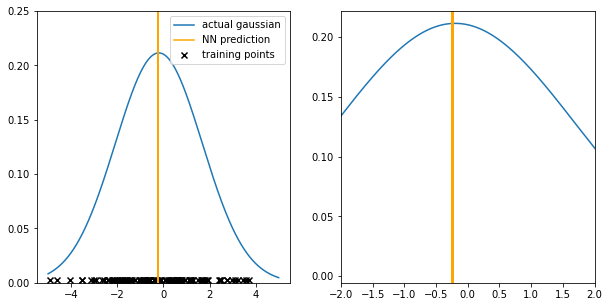

Current epoch number: 334
Epoch 334, train loss: 1.932644, test loss: 1.937004


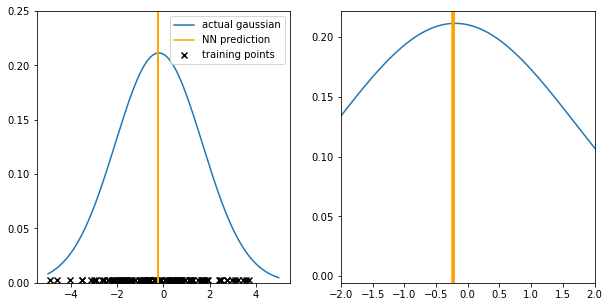

Current epoch number: 339
Epoch 339, train loss: 1.932642, test loss: 1.936983


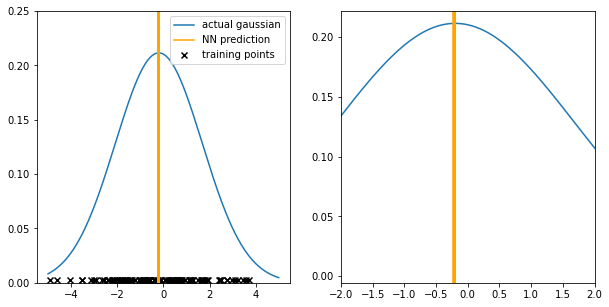

Current epoch number: 344
Epoch 344, train loss: 1.932645, test loss: 1.936990


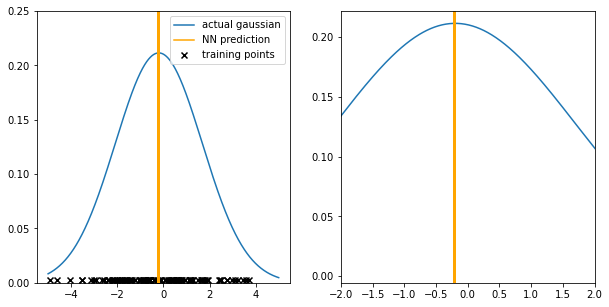

Current epoch number: 349
Epoch 349, train loss: 1.932645, test loss: 1.936995


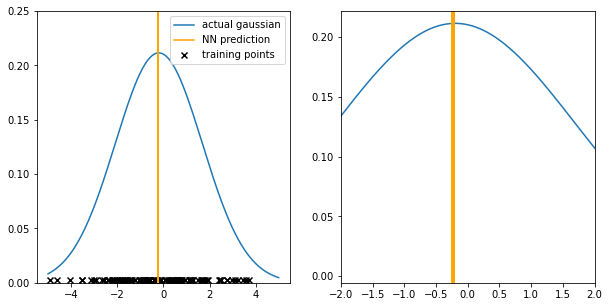

KeyboardInterrupt: 

In [59]:
for e in range(epochs_start, epochs_end):
    prediction = net(train_data)
    loss = likelihood_loss(prediction, -1, train_stats, batch=False) 
    train_loss = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e+1) % 5 == 0 :
        net.eval()
        print("Current epoch number: {}".format(e))
        test_pred = net(test_data)
        loss = likelihood_loss(test_pred, -1,test_stats, batch=False)
        test_loss = loss.item()
        net.train()
        print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
        
        data_index = 101

        test = prediction[data_index]
        x = np.linspace(-5,5,1000)
        y_scipy = scipy.stats.norm( train_stats[data_index][0], train_stats[data_index][1]).pdf(x)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        axes[0].set_ylim([lower_lim,upper_lim])
        axes[1].set_xlim([-2,2])
        axes[0].plot(x,y_scipy, label='actual gaussian')
        axes[1].plot(x,y_scipy, label='actual gaussian')
        for vlines in test:
            axes[0].axvline(x=(vlines), c='orange', label='NN prediction')
            axes[1].axvline(x=(vlines), c='orange', label='NN prediction')
        for points in train_data[data_index]:
            axes[0].scatter(points.cpu(), lower_lim+0.003, marker='x', c='k',label='training points')
        handles, labels = axes[0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[0].legend(by_label.values(), by_label.keys())
        plt.show()
        
#         torch.save({
#             'epoch': e,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'test_loss': test_loss,
#             'train_loss': train_loss
#         }, 'model_ll_dropout_lr_0.001.pt')
        


In [ ]:
prediction = net(train_data)

In [ ]:
net.eval()
pred = net(test_data)

In [ ]:
for i in np.arange(0,1000,21):
    
    plt.hist(test_data[i].cpu())
    plt.hist(pred.detach().cpu().numpy()[i])
    plt.show()